Our attention block plus our text encoder: hashing trick on word stream for input.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
#!pip install numpy==1.16.1
!pip install keras==2.2.4
!wget -nc https://raw.githubusercontent.com/LanceNorskog/deep_meter_2/master/haiku_5.txt
!cut -f2 < haiku_5.txt | sort | uniq > haiku_5_short.txt
!wc -l haiku_5*.txt

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
File ‘haiku_5.txt’ already there; not retrieving.

   95631 haiku_5_short.txt
  673680 haiku_5.txt
  769311 total


In [2]:
!pip uninstall -qy git+https://github.com/LanceNorskog/deep_meter_2#egg=deepmeter
!pip install -q git+https://github.com/LanceNorskog/deep_meter_2#egg=deepmeter


In [3]:

from __future__ import print_function
import math
import pickle
import json
import os
import glob
import time

import numpy as np
import tensorflow as tf
import keras.backend as K
import matplotlib.pyplot as plt

from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Model, Sequential, load_model
from keras import layers 
from keras import metrics
from keras.preprocessing import text
from sklearn.model_selection import train_test_split

from cmu.syllables_cmu import syllables as word2sylls
from cmu.mappers import Decoder, trim_homynyms
from search.full import FullSearch
from cmu.topk import topk as get_top_k
from cmu.wordmap import Wordmap
#from cmu.report import find_top_k_match, report
from keras_stuff.loss import sparse_categorical_crossentropy as scc
from keras_stuff.loss import sparse_categorical_crossentropy_temporal as scct
print(word2sylls['therefore'])

# number of total samples to use
max_data = 100000
# number of words for hashing trick
hash_mole = 20000
# number of output syllables in short haiku
max_features = 16000
# longest output sentence
max_len = 5
# longest input sentence
max_words = 10
# what you think
batch_size = 32
# do not output the same haiku twice
deduplicate_haiku=False
# emit output as input
duplicate_haiku=True
# use long as input
use_big_text=False

model_base="/content/gdrive/My Drive/Colab Notebooks/haiku_hash_5"
model_file=model_base + ".h5".format(int(time.time()))
print(model_file)


Using TensorFlow backend.


['DH EH R', 'F AO R']
/content/gdrive/My Drive/Colab Notebooks/haiku_hash_5.h5


In [4]:
!date
print(word2sylls['door'])
#word2sylls = trim_homynyms(word2sylls)
print(word2sylls['door'])
decoder = Decoder(word2sylls)
syll2idx = decoder.syll2idx
idx2syll = decoder.idx2syll
num_sylls = len(idx2syll)

print(syll2idx['DH EH R'], idx2syll[1])
print('# features: ', len(idx2syll))

for i in range(decoder.wordoff):
    decoder.wordlist[i] = 'word{}'.format(i)
    decoder.wordlength[i] = 1
for i in range(decoder.sylloff):
    decoder.idx2syll[i] = 'syll{}'.format(i)

wordmap = Wordmap(len(decoder.wordlist))


Sat Jul 20 04:58:30 UTC 2019
['D AO R']
['D AO R']
2443 0
# features:  15098


In [5]:
big_text = []
big_hash = []
big_haiku = []
big_data = []
big_data_file = "haiku_5.txt"
haikuwordset = set()
haiku_duped = set()
with open(big_data_file) as f:
    last_haiku = ''
    for line in f.readlines():
        _parts = line.strip().split('\t')
        _text = _parts[0]
        _haiku = _parts[1]
        _sylls = []
        _use_input = True
        if deduplicate_haiku and _haiku == last_haiku:
            #print('fail 1: ', line.strip())
            continue
        _hashed = list(text.hashing_trick(_text, hash_mole))
        if len(_hashed) > max_words:
            #print('fail 4: ', line.strip())
            use_input = False
        _lastidx = -1
        _wordseq = []
        for word in text.text_to_word_sequence(_haiku):
            _word = None
            if not word in word2sylls and word[-2:] == "'s":
                if word[:-2] + 's' in word2sylls:
                    _word = word[:-2] + 's'
                elif word[:-2] + 'es' in word2sylls:
                    _word = word[:-2] + 'es'
                if _word:
                    #print('merged {} => {}'.format(word, _word))
                    word = _word
            if word in word2sylls:
                haikuwordset.add(word)
                for syll in word2sylls[word]:
                    _sylls.append(syll)
                _thisidx = decoder.word2idx[word]
                #print('word {}, idx {}'.format(word, decoder.word2idx[word]))
                if _lastidx != -1:
                    wordmap.add(_lastidx, _thisidx)
                _lastidx = _thisidx
            elif len(word) > 1:
                print('fail 5: ', word)
        if len(_sylls) != 5:
            #print('fail 2: ', _sylls)
            continue
        _data = np.zeros((5), dtype='int32')
        for j in range(5):
             _data[j] = syll2idx[_sylls[j]]
        if use_big_text and _use_input:
            _text_hash = np.zeros((max_words), dtype='int32')
            for j in range(len(_hashed)):
                _text_hash[j] = _hashed[j]
            big_text.append(_text)
            big_hash.append(_text_hash)
            big_haiku.append(_haiku)
            big_data.append(_data)
        if duplicate_haiku and not _haiku in haiku_duped:
            haiku_duped.add(_haiku)
            _haiku_hash = np.zeros((max_words), dtype='int32')
            j = 0
            for h in text.hashing_trick(_haiku, hash_mole):
                _haiku_hash[j] = h
                j += 1
            big_text.append(_haiku)
            big_hash.append(_haiku_hash)
            big_haiku.append(_haiku)
            big_data.append(_data)
        last_haiku = _haiku
        if len(big_text) == max_data:
            print('fail 3: ', line)
            break

big_text = np.array(big_text)
big_hash = np.array(big_hash)
big_haiku = np.array(big_haiku)
big_data = np.array(big_data)
big_data = np.expand_dims(big_data, -1)
print('{}/{} -> {} : {}'.format(big_text[0], big_hash[0], big_haiku[0], big_data[0]))

print('Full length clauses: ', len(big_text))
print('Wordmap total entries: ', wordmap.count())
print('Wordmap length: ', wordmap.length())
print('Haiku duped: ', len(haiku_duped))
haiku_duped = None

fail 5:  caveman's
fail 5:  caveman's
fail 5:  caveman's
fail 5:  smitty's
fail 5:  smitty's
fail 5:  smitty's
fail 5:  frisbee's
fail 5:  frisbee's
fail 5:  frisbee's
fail 5:  pony's
fail 5:  pony's
fail 5:  pony's
fail 5:  mouse's
fail 5:  mouse's
fail 5:  mouse's
fail 5:  tv's
fail 5:  tv's
fail 5:  tv's
fail 5:  shelf's
fail 5:  shelf's
fail 5:  shelf's
fail 5:  tv's
fail 5:  tv's
fail 5:  tv's
fail 5:  shelf's
fail 5:  shelf's
fail 5:  shelf's
fail 5:  tomasino's
fail 5:  tomasino's
fail 5:  tomasino's
fail 5:  tomasino's
fail 5:  tomasino's
fail 5:  tomasino's
fail 5:  emu's
fail 5:  emu's
a white sink and door/[13098 19387 18514  1381 13206     0     0     0     0     0] -> a white sink and door : [[  156]
 [14238]
 [10115]
 [  125]
 [ 1844]]
Full length clauses:  94563
Wordmap total entries:  76410
Wordmap length:  229463
Haiku duped:  94563


In [6]:
# Split multiple datasets
(x_train_i, x_test_i, y_train_i, y_test_i) = train_test_split(np.arange(len(big_data)), np.arange(len(big_data)))

train_len=(len(x_train_i)//batch_size) * batch_size
test_len=(len(x_test_i)//batch_size) * batch_size
x_train = big_hash[x_train_i][:train_len]
y_train = big_data[x_train_i][:train_len]
x_test = big_hash[x_test_i][-test_len:]
y_test = big_data[x_test_i][-test_len:]

print(big_text[x_train_i[0]], x_test[0], str(y_test[0]))

def get_lstm(size, return_sequences=True):
    return layers.CuDNNLSTM(size, return_sequences=return_sequences)

#x_train = np.array(x_train)
#x_test = np.array(x_test)
#y_train = np.expand_dims(y_train, -1)
#y_test = np.expand_dims(y_test, -1)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)
print(y_test[0][0])



to all of her friends [7677 5327 5666    0    0    0    0    0    0    0] [[13020]
 [13726]
 [ 5000]
 [ 1873]
 [10829]]
x_train shape: (70912, 10)
x_test shape: (23616, 10)
y_train shape: (70912, 5, 1)
y_test shape: (23616, 5, 1)
[13020]


In [0]:
# https://github.com/philipperemy/keras-snail-attention/blob/master/attention.py
# Do these Dense layers need activation tanh?
# https://www.d2l.ai/chapter_attention-mechanism/attention.html
# k, q have attention, v does not?
class AttentionBlock(layers.Layer):

    def __init__(self, dims, k_size, v_size, seq_len=None, **kwargs):
        self.k_size = k_size
        self.seq_len = seq_len
        self.v_size = v_size
        self.dims = dims
        self.sqrt_k = math.sqrt(k_size)
        self.keys_fc = None
        self.queries_fc = None
        self.values_fc = None
        super(AttentionBlock, self).__init__(**kwargs)

    def build(self, input_shape):
        # https://stackoverflow.com/questions/54194724/how-to-use-keras-layers-in-custom-keras-layer
        self.keys_fc = layers.Dense(self.k_size)
        self.keys_fc.build((None, self.dims))
        self._trainable_weights.extend(self.keys_fc.trainable_weights)

        self.queries_fc = layers.Dense(self.k_size)
        self.queries_fc.build((None, self.dims))
        self._trainable_weights.extend(self.queries_fc.trainable_weights)

        self.values_fc = layers.Dense(self.v_size)
        self.values_fc.build((None, self.dims))
        self._trainable_weights.extend(self.values_fc.trainable_weights)

    def call(self, inputs, **kwargs):
        # check that the implementation matches exactly py torch.
        keys = self.keys_fc(inputs)
        queries = self.queries_fc(inputs)
        values = self.values_fc(inputs)
        logits = K.batch_dot(queries, K.permute_dimensions(keys, (0, 2, 1)))
        mask = K.ones_like(logits) * np.triu((-np.inf) * np.ones(logits.shape.as_list()[1:]), k=1)
        logits = mask + logits
        probs = layers.Softmax(axis=-1)(logits / self.sqrt_k)
        read = K.batch_dot(probs, values)
        output = K.concatenate([inputs, read], axis=-1)
        return output

    def compute_output_shape(self, input_shape):
        output_shape = list(input_shape)
        output_shape[-1] += self.v_size
        return tuple(output_shape)



In [8]:
def sparse_categorical_accuracy(y_true, y_pred):
    # reshape in case it's in shape (num_samples, 1) instead of (num_samples,)
    if K.ndim(y_true) == K.ndim(y_pred):
        y_true = K.squeeze(y_true, -1)
    # convert dense predictions to labels
    y_pred_labels = K.argmax(y_pred, axis=-1)
    y_pred_labels = K.cast(y_pred_labels, K.floatx())
    return K.cast(K.equal(y_true, y_pred_labels), K.floatx())

def sparse_categorical_accuracy_per_sequence(y_true, y_pred):
    # reshape in case it's in shape (num_samples, 1) instead of (num_samples,)
    if K.ndim(y_true) == K.ndim(y_pred):
        y_true = K.squeeze(y_true, -1)
    # convert dense predictions to labels
    y_pred_labels = K.argmax(y_pred, axis=-1)
    y_pred_labels = K.cast(y_pred_labels, K.floatx())
    return K.min(K.cast(K.equal(y_true, y_pred_labels), K.floatx()), axis=-1)

def sparse_temporal_top_k_categorical_accuracy(y_true, y_pred, k=5):
    original_shape = K.shape(y_true)
    y_true = K.reshape(y_true, (-1, K.shape(y_true)[-1]))
    y_pred = K.reshape(y_pred, (-1, K.shape(y_pred)[-1]))
    top_k = K.in_top_k(y_pred, K.cast(K.max(y_true, axis=-1), 'int32'), k)
    return K.reshape(top_k, original_shape[:-1])

def sparse_temporal_top_k_categorical_accuracy_per_sequence(y_true, y_pred, k=5):
    original_shape = K.shape(y_true)
    y_true = K.reshape(y_true, (-1, K.shape(y_true)[-1]))
    y_pred = K.reshape(y_pred, (-1, K.shape(y_pred)[-1]))
    top_k = K.in_top_k(y_pred, K.cast(K.max(y_true, axis=-1), 'int32'), k)
    perfect = K.min(K.cast(top_k, 'int32'), axis=-1)
    return perfect #K.expand_dims(perfect, axis=-1)

def sparse(y_true, y_pred):
    return sparse_categorical_accuracy(y_true, y_pred)
def sparse1(y_true, y_pred):
    return sparse_temporal_top_k_categorical_accuracy(y_true, y_pred, k=1)
def perfect(y_true, y_pred):
    return sparse_categorical_accuracy_per_sequence(y_true, y_pred)
def perfect1(y_true, y_pred):
    return sparse_temporal_top_k_categorical_accuracy_per_sequence(y_true, y_pred, k=1)
def sparse5(y_true, y_pred):
    return sparse_temporal_top_k_categorical_accuracy(y_true, y_pred, k=5)
def perfect5(y_true, y_pred):
    return sparse_temporal_top_k_categorical_accuracy_per_sequence(y_true, y_pred, k=5)
def fscore(y_true, y_pred):
    recall = K.mean(sparse_categorical_accuracy(y_true, y_pred))
    precision = K.mean(sparse_categorical_accuracy_per_sequence(y_true, y_pred))
    return 2 * ((recall * precision)/(recall + precision))

def sparse_loss(y_true, y_pred):
    return scc(y_true, y_pred)

def perfect_loss(y_true, y_pred):
    return scct(y_true, y_pred, scale=1.0)

embed_size=512
units_k=embed_size
units_v=embed_size
units_v=embed_size//3
units=512
dropout=0.5

metric_list = [sparse, perfect]
metric_names = ['sparse', 'perfect']

hash_input = layers.Input(shape=(max_words,), dtype='int32')
x = layers.Embedding(hash_mole, embed_size, input_length=max_words)(hash_input)
x = layers.Dropout(dropout)(x)
#x = layers.Dense(units, activation='relu')(x)
#x = layers.RepeatVector(max_words)(x)
x = layers.Bidirectional(get_lstm(units//2, return_sequences=False))(x)
if False:
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(unit_medium, activation='relu')(x)
if False:
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(unit_small, activation='relu')(x)
if True:
    x = layers.Dropout(dropout)(x)
    x = layers.RepeatVector(max_len)(x)
    x = layers.Dropout(dropout)(x)
    x = AttentionBlock(embed_size, k_size=units_k, v_size=units_v)(x)
    x = layers.Flatten()(x)
x = layers.RepeatVector(max_len)(x)
if False:
    x = layers.Dropout(dropout)(x)
    x = AttentionBlock(embed_size, k_size=units_k, v_size=units_v)(x)
x = layers.Dropout(dropout)(x)
x = get_lstm(units, return_sequences=True)(x)
if True:
    x = layers.Dropout(dropout)(x)
    x = AttentionBlock(embed_size, k_size=units_k, v_size=units_v)(x)
x = layers.Dropout(dropout)(x)
output_layer = layers.Dense(max_features, activation='softmax')(x)


model = Model(inputs=[hash_input], outputs=output_layer)
model.compile('adam', sparse_loss, metrics=metric_list)
model.summary()

# try using different optimizers and different optimizer configs

print('Train...')
history = None
use_saved_model=False
if not use_saved_model or not os.path.exists(model_file):
  with tf.Session() as session:
    K.manual_variable_initialization(False)
    model_file=model_base + ".h5".format(int(time.time()))
    K.set_session(session)
    session.run(tf.global_variables_initializer())
    session.run(tf.tables_initializer())

    history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=300,
          callbacks=[EarlyStopping(monitor='val_perfect', mode='max', verbose=1, patience=10),
            ModelCheckpoint(model_file, monitor='val_perfect', save_best_only=True, save_weights_only=True, mode='max', verbose=0)],
          verbose=2,
          validation_data=[x_test, y_test])


W0720 04:58:57.788864 139657408362368 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0720 04:58:57.805070 139657408362368 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0720 04:58:57.809039 139657408362368 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0720 04:58:57.822956 139657408362368 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0720 04:58:57.831277 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 10)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 10, 512)           10240000  
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 512)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 512)               1576960   
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 5, 512)            0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 5, 512)            0         
__________

W0720 04:59:00.771582 139657408362368 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 70912 samples, validate on 23616 samples
Epoch 1/300
 - 106s - loss: 4.5393 - sparse: 0.2777 - perfect: 0.0014 - val_loss: 2.9253 - val_sparse: 0.4906 - val_perfect: 0.0354
Epoch 2/300
 - 103s - loss: 2.9939 - sparse: 0.4549 - perfect: 0.0231 - val_loss: 1.9518 - val_sparse: 0.6528 - val_perfect: 0.1751
Epoch 3/300
 - 103s - loss: 2.3563 - sparse: 0.5457 - perfect: 0.0677 - val_loss: 1.4566 - val_sparse: 0.7395 - val_perfect: 0.3189
Epoch 4/300
 - 103s - loss: 1.9902 - sparse: 0.6028 - perfect: 0.1152 - val_loss: 1.2088 - val_sparse: 0.7888 - val_perfect: 0.4212
Epoch 5/300
 - 104s - loss: 1.7402 - sparse: 0.6449 - perfect: 0.1598 - val_loss: 1.0203 - val_sparse: 0.8226 - val_perfect: 0.4962
Epoch 6/300
 - 103s - loss: 1.5591 - sparse: 0.6756 - perfect: 0.1986 - val_loss: 0.9006 - val_sparse: 0.8444 - val_perfect: 0.5532
Epoch 7/300
 - 103s - loss: 1.4250 - sparse: 0.6996 - perfect: 0.2299 - val_loss: 0.8300 - val_sparse: 0.8595 - val_perfect: 0.5918
Epoch 8/300
 - 103s - loss

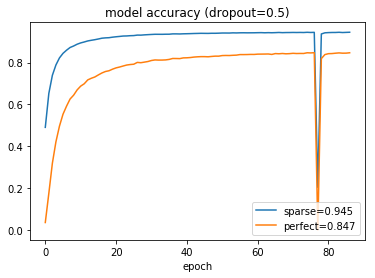

In [9]:

plt.figure()
if history != None:
  # summarize history for accuracy
  for m in metric_names:
      #plt.plot(history.history[m])
      plt.plot(history.history['val_' + m])
  plt.title('model accuracy (dropout={})'.format(dropout))
  plt.xlabel('epoch')
  sname = []
  for m in metric_names:
      sname.append('{}={:01.3f}'.format(m, history.history['val_' + m][-1]))
  plt.legend(sname, loc='lower right')
  plt.show()

In [10]:
with tf.Session() as session:
  K.set_session(session)
  session.run(tf.global_variables_initializer())
  session.run(tf.tables_initializer())
  model.load_weights(model_file)  
  eval_small = model.evaluate(x_test, y_test)
  print('model.evaluate on test data: ' ,model.metrics_names, eval_small)
  print('history: ', history)


  288/23616 [..............................] - ETA: 27s

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f03ccecbba8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1473, in __del__
    self._session._session, self._handle)
tensorflow.python.framework.errors_impl.CancelledError: (None, None, 'Session has been closed.')


23616/23616 [==============================] - 7s 309us/step
model.evaluate on test data:  ['loss', 'sparse', 'perfect'] [0.38310739803342475, 0.944977980803668, 0.8477726964769647]
history:  <keras.callbacks.History object at 0x7f043089c978>


In [0]:
def find_top_k_match(data, prediction, top_k=5):
        out = [-1] * len(data)
        for i in range(len(data)):
            topind = np.argsort(prediction[i])
            topind = topind[-top_k:]
            for j in range(top_k):
                #print(data[i][0], topind[j])
                if data[i][0] == topind[j]:
                    out[i] = topind[j]
        return out
    
def report(data, prediction):
    def match(data, prediction):
        assert len(data.shape) == 2
        assert len(prediction.shape) == 2
        good = 0
        top5 = 0
        count = 0
        for i in range(len(data)):
            topind = np.argsort(prediction[i])
            if data[i][0] == topind[-1]:
                good += 1
            topind = topind[-5:len(topind)]
            for j in range(5):
                if data[i][0] == topind[j]:
                    top5 += 1
                    break
            count += 1
        return (good, top5, count)

    _sparse = 0.0
    _perfect = 0.0
    _sparse5 = 0.0
    _perfect5 = 0.0
    _total = 0
    for n in range(len(data)):
        #print(len(short[n]))
        (good, top5, count) = match(data[n], predicts[n])
        if count == 0:
            continue
        _sparse += good/count
        _sparse5 += top5/count
        if good == count:
            _perfect += 1  
        if top5 == count:
            _perfect5 += 1
        _total += 1
    return {'sparse':_sparse/_total, 'perfect': _perfect/_total, 'sparse5': _sparse5/_total, 'perfect5': _perfect5/_total}


In [0]:
top_k=5

fs = FullSearch(top_k * top_k * top_k, 5, top_k)
def decodem(predict, top_k):
    global fs
    (top_vals, top_paths) = get_top_k(np.array([predict]), top_k=top_k)
    #print('top_paths: ' + str(top_paths))
    #print(top_paths.shape)
    fs.mainloop(top_paths[0])
    #print('score[0]: {}'.format(fs.scorevals[0]))
    #print('paths[0]: {}'.format(fs.scorepaths[0]))
    #print('score[-1]: {}'.format(fs.scorevals[-1]))
    #print('paths[-1]: {}'.format(fs.scorepaths[-1]))
    #print('min {}, max {}'.format(np.min(fs.scorevals), np.max(fs.scorevals)))
    morepaths = np.zeros(fs.scorepaths.shape, dtype='int32')
    for j in range(fs.scorepaths.shape[0]):
        #print('scorepaths[{}]: {}'.format(j, fs.scorepaths[j]))
        #print('predict.shape: ', predict.shape)
        #print('top_paths.shape: ', top_paths.shape)
        #print('top_paths[{}]: {}'.format(j, top_paths))
        #print('top_paths[{}][]: {}'.format(j, top_paths[0][np.arange(max_len), fs.scorepaths[j]]))
        morepaths[j] = top_paths[0][np.arange(max_len), fs.scorepaths[j]]
    #print('morepaths: ' + str(morepaths))
    encoded = decoder.get_sentences(morepaths)
    sentences = {}
    if len(encoded) > 0:
        #print(encoded)
        decoded = []
        for e1 in encoded:
            if len(e1) > 0 and len(e1[0]) > 0:
                dec = decoder.decode_sentences([e1])
                decoded.append(dec)
        for d1 in decoded:
            for d2 in d1:
                for d3 in d2:
                    for d4 in d3:
                        go = True
                        _lastidx = -1
                        for w in d4:
                            if not w in haikuwordset:
                                go = False
                            _idx = decoder.word2idx[w]
                            if _lastidx > 0:
                                if _lastidx == _idx or not wordmap.get(_lastidx, _idx):
                                    go = False
                                    #print('Fail: {},{} {},{}'.format(_lastidx, _idx, _lastword, w))
                            _lastidx = _idx
                            _lastword = w
                        if go:
                            key = ' '.join(d4)
                            sentences[key] = d4
                    #print('d3: ', d3)
                    #key = ' '.join(d3)
                    #sentences[key] = d3
    return sentences

# return N possible sentences with the fewest words
def short_sentences(sentences):
    out = {}
    for i in range(1, max_len + 1):
        for (k, v) in sentences.items():
            if len(v) == i:
                out[k] = v
        if len(out) > 4:
            return out
    return out

In [0]:
   
bigbatch = batch_size * 32
with tf.Session() as session:
  K.set_session(session)
  session.run(tf.global_variables_initializer())
  session.run(tf.tables_initializer())
  model.load_weights(model_file)  
  biglen = len(x_test)
  for i in range(0, biglen, bigbatch):
      predicts = model.predict(x_train[i:i + bigbatch], batch_size=bigbatch)
      for j in range(0, len(predicts)):
          #f = find_top_k_match(y_test[i + j], predicts[j], 5)
          #if np.min(f) > 0 and j == 0:
          #    print('{} -> {}'.format(x_test[i + j], [decoder.idx2syll[k] for k in f]))
          sentences = decodem(predicts[j], 5)
          if len(sentences) > 0:
              for s in short_sentences(sentences):
                    print('{} -> {}'.format(big_text[x_train_i][i + j], s))
              #print('{} -> {}'.format(x_test[i + j], sentences[0]))
              #for k in range(1, len(sentences)):
              #      print('. -> {}'.format(sentences[k]))
    

to all of her friends -> with some in the straw
to all of her friends -> with plants in the straw
to all of her friends -> to some in the straw
to all of her friends -> to rose in the straw
to all of her friends -> to plants in the straw
to all of her friends -> two plants in the straw
to all of her friends -> with some in the pan
the green city bus -> sil tall city stop
the green city bus -> sill tall city stop
the green city bus -> sil old city stop
the green city bus -> sill old city stop
the large, old steam train -> the small red tile work
the large, old steam train -> a small red tile work
the large, old steam train -> an small red tile work
the large, old steam train -> the old red tile work
the large, old steam train -> on small red tile work
the large, old steam train -> the small red steam train
a blonde haired woman -> with blond young woman
a blonde haired woman -> with blond young women
on to of a field -> into two long sink
on to of a field -> into two the snow
on to of a

In [0]:

(mini_vals, mini_preds) = get_top_k(np.array(predicts), top_k=top_k)
#print('top preds: ', mini_preds[0])
#print(mini_preds.shape)
total = 0
_go = []
for x in mini_preds[0]:
            _go.append(decoder.idx2syll[x[0]])
print('{} -> {}'.format(x_short[0], str(_go)))
for i in range(len(mini_preds)):
    fs = FullSearch(top_k * top_k * top_k, 5, top_k)
    fs.mainloop(mini_preds[i])
    #print('score[0]: {}'.format(fs.scorevals[0]))
    #print('paths[0]: {}'.format(fs.scorepaths[0]))
    #print('score[-1]: {}'.format(fs.scorevals[-1]))
    #print('paths[-1]: {}'.format(fs.scorepaths[-1]))
    #print('min {}, max {}'.format(np.min(fs.scorevals), np.max(fs.scorevals)))
    print('{} -> {}'.format(x_short[i], [decoder.idx2syll[x] for x in fs.scorepaths[0]]))
    morepaths = np.zeros(fs.scorepaths.shape, dtype='int32')
    print(mini_preds[i].shape)
    print(morepaths.shape)
    for j in range(fs.scorepaths.shape[0]):
        #print(fs.scorepaths[j])
        #z = mini_preds[i][np.arange(max_len), fs.scorepaths[j]]
        #print(z)
        morepaths[j] = mini_preds[i][np.arange(max_len), fs.scorepaths[j]]
    #print(morepaths[0])
    encoded = decoder.get_sentences(morepaths)
    if i == 0:
        print('encoded[0]: ', encoded[0])
    #d = []
    # for x in encoded:
    #   for y in x:
    #        if len(y) > 0:
    #           d.append(y[0])  
    #d = np.array(d)
    d = encoded
    if len(d) > 0:
        print('encoded sentences: ', d)
        print(x_short[i], ':')
        #print(mini_preds[0])
        total += 1
        decoded = decoder.decode_sentences(encoded)
        #print('len(decoded): ', len(decoded))
        ##print('len(decoded[0]): ', len(decoded[0]))
        #print('len(decoded[0][0]): ', len(decoded[0][0]))
        #print('len(decoded[0][0][0]): ', len(decoded[0][0][0]))
        #print('decoded[0][0][0]: ', decoded[0][0][0])
        sentences = {}
        for d1 in decoded:
            for d2 in d1:
                for d3 in d2:
                    print('d3: ', d3)
                    break
                    key = ' '.join(d3)
                    sentences[key] = d3
                    break
                     
        print('[{}]  -> {}', i,list(sentences.keys())[0:10])
    break
print('Total decoded: {}'.format(total))

In [0]:
with tf.Session() as session:
  #K.manual_variable_initialization(True)  
  K.set_session(session)
  session.run(tf.global_variables_initializer())
  session.run(tf.tables_initializer())
  #model = load_model(model_file)  
  model.load_weights(model_file)  
  eval_small = model.evaluate(test_x, test_y)
  print('model.evaluate on haiku clauses: ' ,model.metrics_names, eval_small)
  print('history: ', history)
  eval_big = model.evaluate(big_text, big_data)
  print('model.evaluate on long clauses: ' ,model.metrics_names, eval_big)
  print('history: ', history)
  biglen = len(big_text)
  #for i in range(0, len(big_text), batch_size):
  #  predicts = model.predict(big_text[i:i + batch_size], batch_size=batch_size)
  #  print('shape: {}'.format(predicts.shape))


In [0]:
metric_list = [sparse, perfect, sparse5, perfect5]
metric_names = ['sparse', 'perfect', 'sparse5', 'perfect5']

model = Model(inputs=[input_text], outputs=output_layer)
model.compile('adam', 'sparse_categorical_crossentropy', metrics=metric_list)

bigbatch = batch_size * 32
big_text = np.array(big_text)
big_haiku = np.array(big_haiku)
text5arr = []
haiku5mean = None
with tf.Session() as session:
  #K.manual_variable_initialization(True)  
  K.set_session(session)
  session.run(tf.global_variables_initializer())
  session.run(tf.tables_initializer())
  #model = load_model(model_file)  
  model.load_weights(model_file)  
  predicts = model.predict(big_haiku[0: bigbatch], batch_size=bigbatch)
  rep = report(big_data[0: bigbatch], predicts)
  print("short {}".format(rep))
  haiku5mean = rep['perfect5']
  biglen = len(big_text)
  for i in range(0, biglen, bigbatch):
    predicts = model.predict(big_text[i:i + bigbatch], batch_size=bigbatch)
    rep = report(big_data[i:i + bigbatch], predicts)
    print("[{}] {}".format(i, rep))
    text5arr.append(rep['perfect5'])

text5mean = np.mean(np.array(text5arr))

In [0]:
val5arr = []
with tf.Session() as session:
  #K.manual_variable_initialization(True)  
  K.set_session(session)
  session.run(tf.global_variables_initializer())
  session.run(tf.tables_initializer())
  #model = load_model(model_file)  
  model.load_weights(model_file)  
  biglen = len(x_test)
  for i in range(0, biglen, bigbatch):
    predicts = model.predict(x_test[i:i + bigbatch], batch_size=bigbatch)
    rep = report(y_test[i:i + bigbatch], predicts)
    print("[{}] {}".format(i, rep))
    val5arr.append(rep['perfect5'])

val5mean = np.mean(np.array(val5arr))

In [0]:
print('Perfect5 for all haiku lines: {}, all mscoco lines: {}, validation mscoco: {}'.format(haiku5mean, text5mean, val5mean))